# Final Resource

final resource as a RMarkdown webpage

- The purpose of your topic is clearly captured in your resource
- Quantitative questions are clearly and concisely explained with thoughtful text and compelling visuals
- A nuanced understanding of the important features of the dataset and topic is demonstrated.
- High-level insights (important descriptive information, major trends, notable outliers, etc.) should be prominent in your resource.
- Methods and results of statistical approaches are clear
- Your analysis should be easily reproducible using information in your GitHub repository
- Remember to tailor your resource to a specific target audience. The amount of framing you need to do for a scientific versus general audience is quite different

https://www.kaggle.com/pvkc8888/dota-2-pro-circuit-1718

https://dota2.gamepedia.com/Game_Versions

In [7]:
# Import packages
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import math
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from data_functions import *

In [3]:
dpc = pd.read_json("data/DPC.json").transpose()

In [4]:
dpc.drop(["all_word_counts", "barracks_status_dire", "barracks_status_radiant", "chat", "cluster", "comeback", 
          "cosmetics", "dire_score", "series_type", "skill", "stomp", "teamfights", "throw", "tower_status_dire", 
          "tower_status_radiant", "loss", "leagueid", "duration", "engine", "first_blood_time", "radiant_xp_adv", 
          "replay_url", "radiant_gold_adv", "positive_votes", "radiant_score", "negative_votes", 
          "objectives", "dire_team_id", "radiant_team_id", "human_players", "league", "lobby_type", 
          "draft_timings", "my_word_counts", "region", "replay_salt", "series_id"], axis=1, inplace=True)
dpc.drop([1], inplace=True)

In [118]:
# (7.06, 7.07, 7.08, 7.09, 7.10, 7.11, 7.12, 7.13, 7.14, 7.15, 7.16, 7.16)
# major patches
# patch 7.07 to 7.09 (patch 26 to 28)
# patch 7.10 to 7.13 (patch 29 to 32)
# patch 7.14 to 7.16 (patch 33 to 36)

# for data with picks and bans
# for hero data https://github.com/kronusme/dota2-api/blob/master/data/heroes.json

In [119]:
# has radiant picks/bans, dire picks/bans, team_ids, radiant win(true/false)
patch707_combined = create_pick_ban_both_teams(dpc, 26, 28)
patch710_combined = create_pick_ban_both_teams(dpc, 29, 32)
patch714_combined = create_pick_ban_both_teams(dpc, 33, 36)
patchAll_combined = create_pick_ban_both_teams(dpc, 26, 36)

In [ ]:
# has data for pick, ban, and win
patch707_single = create_pick_ban_1_team(dpc, 26, 28)
patch710_single = create_pick_ban_1_team(dpc, 29, 32)
patch714_single = create_pick_ban_1_team(dpc, 33, 36)
patchAll_single = create_pick_ban_1_team(dpc, 26, 36)

In [ ]:
# has data for pick, ban, win, team_id
patch707_pbt = create_pick_ban_team(dpc, 26, 28)
patch710_pbt = create_pick_ban_team(dpc, 29, 32)
patch714_pbt = create_pick_ban_team(dpc, 33, 36)
patchAll_pbt = create_pick_ban_team(dpc, 26, 36)

In [ ]:
# these are data with picks, team_id, and win (true, false)
patch707_picks_team = create_picks_team(dpc, 26, 28)
patch710_picks_team = create_picks_team(dpc, 29, 32)
patch714_picks_team = create_picks_team(dpc, 33, 36)
patchAll_picks_team = create_picks_team(dpc, 26, 36)

In [50]:
# these are data with only picks and win (true,false)
patch707_picks = create_picks(dpc, 26, 28)
patch710_picks = create_picks(dpc, 29, 32)
patch714_picks = create_picks(dpc, 33, 36)
patchAll_picks = create_picks(dpc, 26, 36)

# Below is only for testing on small subset of data

In [46]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

In [8]:
# Does bans matter
# Does Team ID matter
# Only Picks
# based off patch

hero_df, win_df = create_vector(dpc, 26, 27)
hero_test_df, win_test_df = create_vector(dpc, 28, 28)

In [37]:
results = []
comb = []

layers = np.arange(0, 10)
layers = layers[10:0:-1]
for n in np.arange(1, 50):
    for l in layers:
        clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(n, l), random_state=1)
        clf.fit(hero_df, win_df.values.ravel())

        results.append(accuracy_score(clf.predict(hero_test_df), win_test_df))
        comb.append(str(n) + " " + str(l))

In [43]:
counter = 0
maxP = 0
maxPL = 0
for x in results:
    if maxP < x:
        maxP = x
        maxPL = counter
    counter += 1
print(maxPL)
print(maxP)
print(comb[maxPL])

len(results)

71
0.625
8 1


441

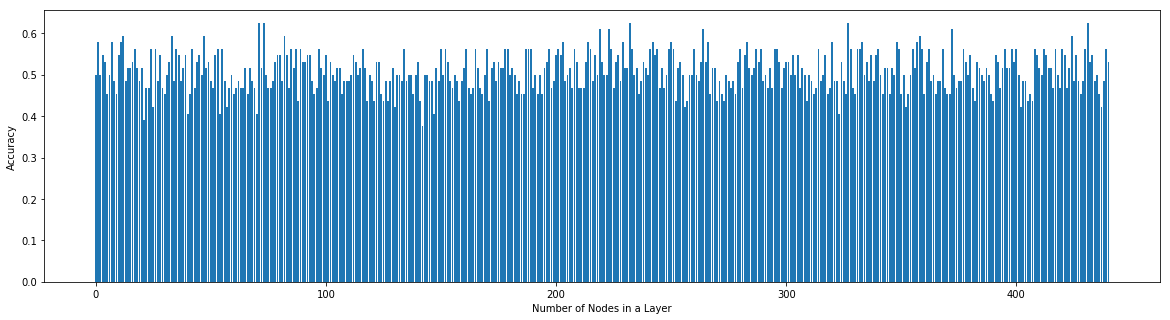

In [44]:
plt.figure(figsize=(20, 5))
plt.bar(np.arange(0, 441), results)
plt.xlabel("Number of Nodes in a Layer")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
def create_shuffle_vector(data, patch_range_low, patch_range_high):
    """
    takes in data and range of patch numbers and returns 
    1st dataframe with both teams' picks, and bans
    2nd datafram with if the team that had first pick won
    """
    hero_df = pd.DataFrame()
    win_df = pd.DataFrame()
    
    for i in data.index: 
        patch = data.at[i, 'patch']
        game_mode = data.at[i, 'game_mode']
        if patch >= patch_range_low and patch <= patch_range_high and game_mode == 2: 
            length = len(data.at[i, 'picks_bans'])
            if  length == 22:
                ban1 = data.at[i, "picks_bans"][0]["hero_id"]
                ban6 = data.at[i, "picks_bans"][1]["hero_id"]
                ban2 = data.at[i, "picks_bans"][2]["hero_id"]
                ban7 = data.at[i, "picks_bans"][3]["hero_id"]
                ban3 = data.at[i, "picks_bans"][4]["hero_id"]
                ban8 = data.at[i, "picks_bans"][5]["hero_id"]

                pick1 = data.at[i, "picks_bans"][6]["hero_id"]
                pick6 = data.at[i, "picks_bans"][7]["hero_id"]
                pick7 = data.at[i, "picks_bans"][8]["hero_id"]
                pick2 = data.at[i, "picks_bans"][9]["hero_id"]

                ban9 = data.at[i, "picks_bans"][10]["hero_id"]
                ban4 = data.at[i, "picks_bans"][11]["hero_id"]
                ban10 = data.at[i, "picks_bans"][12]["hero_id"]
                ban5 = data.at[i, "picks_bans"][13]["hero_id"]

                pick8 = data.at[i, "picks_bans"][14]["hero_id"]
                pick3 = data.at[i, "picks_bans"][15]["hero_id"]
                pick9 = data.at[i, "picks_bans"][16]["hero_id"]
                pick4 = data.at[i, "picks_bans"][17]["hero_id"]  

                ban11 = data.at[i, "picks_bans"][18]["hero_id"]
                ban6 = data.at[i, "picks_bans"][19]["hero_id"]

                pick5 = data.at[i, "picks_bans"][20]["hero_id"]
                pick10 = data.at[i, "picks_bans"][21]["hero_id"] 

                radiantWin = data.at[i, "radiant_win"]
                
                team1 = pd.Series({"pick_1": pick1, "pick_2": pick2, "pick_3": pick3, "pick_4": pick4, "pick_5": pick5})
                player1_hero = data.at[i, "players"][0]["hero_id"]
                player1_first_pick = False
                player1_radiant = data.at[i, "players"][0]["isRadiant"]
                picks_bans = {}
                
                firstWin = data.at[i, 'radiant_win']
                
                hero_vector = np.zeros((4, 121))
                
                for hero in team1:
                    if hero == player1_hero:
                        player1_first_pick = True
                if not player1_first_pick:
                    firstWin = not data.at[i, 'radiant_win']

                    
                picks_bans = [pick1, pick2, pick3, pick4, pick5,
                              ban1, ban2, ban3, ban4, ban5, ban6,
                              pick6, pick7, pick8, pick9, pick10,
                              ban6, ban7, ban8, ban9,  ban10, ban11] 
                
                pick_b = True
                for v_row in hero_vector:
                    for pb in picks_bans:
                        if pick_b:
                            for i in np.arange(5):
                                v_row[pb] = 1;
                            pick_b = False
                        else:
                            for i in np.arange(6):
                                v_row[pb] = 1;
                            pick_b = True
                
                try:
                    math.isnan(int(firstWin))
                except TypeError:
                    continue
                
                hero_vector = np.concatenate((hero_vector[0], hero_vector[1], hero_vector[2], hero_vector[3]), axis=None)
                hero_df = hero_df.append(pd.Series(hero_vector), ignore_index=True)
                
                win_df = win_df.append(pd.Series(firstWin), ignore_index=True)

    return hero_df, win_df

In [50]:
results_s = []
comb_s = []
counter = 0
maxP = 0
maxPL = 0

for x in np.arange(0, 10):
    dpc = shuffle(dpc, random_state=x)
    hero_df, win_df = create_vector(dpc, 26, 27)
    hero_test_df, win_test_df = create_vector(dpc, 28, 28)
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(8, 1), random_state=1)
    clf.fit(hero_df, win_df.values.ravel())

    results_s.append(accuracy_score(clf.predict(hero_test_df), win_test_df))

print(maxPL)
print(maxP)
print(comb[maxPL])

print(results_s)

9
9
2 9
[0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625]


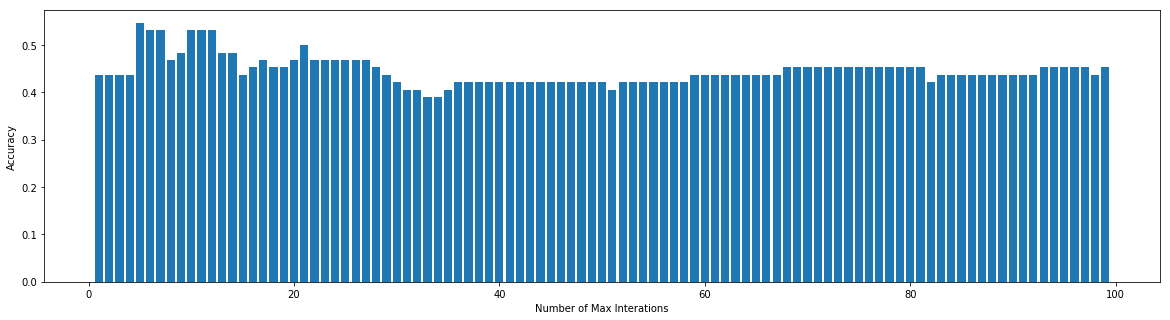

In [13]:
result_iter = []

for x in np.arange(1, 100):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 2), random_state=1, max_iter=x)
    clf.fit(hero_df, win_df.values.ravel())

    result_iter.append(accuracy_score(clf.predict(hero_test_df), win_test_df))

plt.figure(figsize=(20, 5))
plt.bar(np.arange(1, 100), result_iter)
plt.xlabel("Number of Max Interations")
plt.ylabel("Accuracy")
plt.show()

In [12]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 2), random_state=1, early_stopping=True)
clf.fit(hero_df, win_df.values.ravel())
print(accuracy_score(clf.predict(hero_test_df), win_test_df))

clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10, 2), random_state=1, early_stopping=True)
clf.fit(hero_df, win_df.values.ravel())
print(accuracy_score(clf.predict(hero_test_df), win_test_df))

clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(10, 2), random_state=1, early_stopping=True)
clf.fit(hero_df, win_df.values.ravel())
print(accuracy_score(clf.predict(hero_test_df), win_test_df))

0.4375
0.4375
0.4375


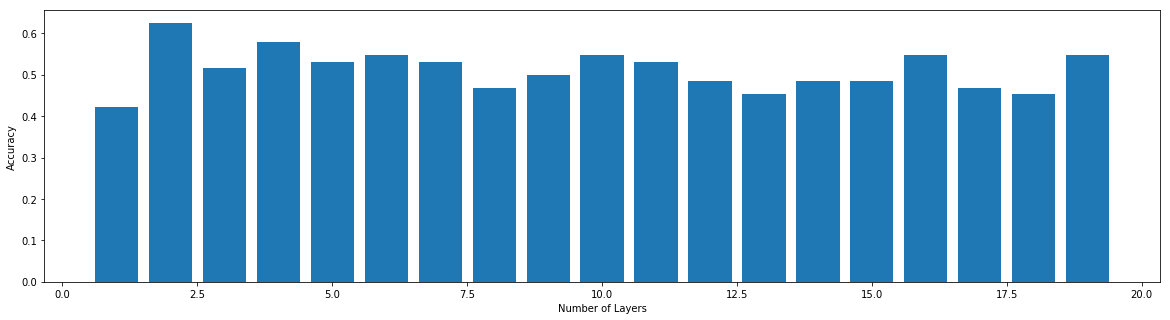

In [275]:
result_layer = []

for x in np.arange(1, 20):
    clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, x), random_state=1, max_iter=1000)
    clf.fit(hero_df, win_df.values.ravel())

    result_layer.append(accuracy_score(clf.predict(hero_test_df), win_test_df))

plt.figure(figsize=(20, 5))
plt.bar(np.arange(1, 20), result_layer)
plt.xlabel("Number of Layers")
plt.ylabel("Accuracy")
plt.show()


In [39]:
hero_df, win_df = create_vector(dpc, 26, 34)
hero_test_df, win_test_df = create_vector(dpc, 35, 36)

result_comb = []
comb = []

counter = 0
maxP = 0
maxPL = 0

# for x in ['identity', 'logistic', 'tanh', 'relu']:
for x in ['relu']:
     for a in np.arange(0.001, 0.01, 0.001):
        for b in np.arange(0.01, 1, 0.1):
            for b2 in np.arange(0.001, 0.01, 0.001):
                 for n in np.arange(1, 5):
                    for l in np.arange(1, 5):
                        clf = MLPClassifier(activation=x, solver='adam', alpha=a, hidden_layer_sizes=(n, l), 
                                            random_state=1, early_stopping=True, beta_1=b, beta_2=b2)
                        clf.fit(hero_df, win_df.values.ravel())
                        score = accuracy_score(clf.predict(hero_test_df), win_test_df)
                        result_comb.append(score)
                        comb.append(str(a) + " " + str(b) + " " + str(b2) + " " + str(n) + " " + str(l))
                        if maxP < score:
                            maxP = score
                            maxPL = counter
                        counter += 1
print(maxPL)
print(maxP)
print(comb[maxPL])

2765
0.6330275229357798
0.002 0.91 0.002 4 2


In [47]:
# clf = MLPClassifier(activation=x, solver='adam', alpha=a, hidden_layer_sizes=(n, l), 
#                     random_state=1, max_iter=200, beta_1=b, beta_2=b2, early_stopping=True)
# clf.fit(hero_df, win_df.values.ravel())
# result_comb.append(accuracy_score(clf.predict(hero_test_df), win_test_df))
counter = 0
maxP = 0
maxPL = 0
for x in result_comb:
    if maxP < x:
        maxP = x
        maxPL = counter
    counter += 1
print(maxPL)
print(maxP)
print(comb[maxPL])

for x in np.arange(7000, 8000):
    if result_comb[x] > 0.63:
        print(x)
        print(result_comb[x])
        print(comb[x])

2765
0.6330275229357798
0.002 0.91 0.002 4 2
7085
0.6330275229357798
0.005 0.91 0.002 4 2


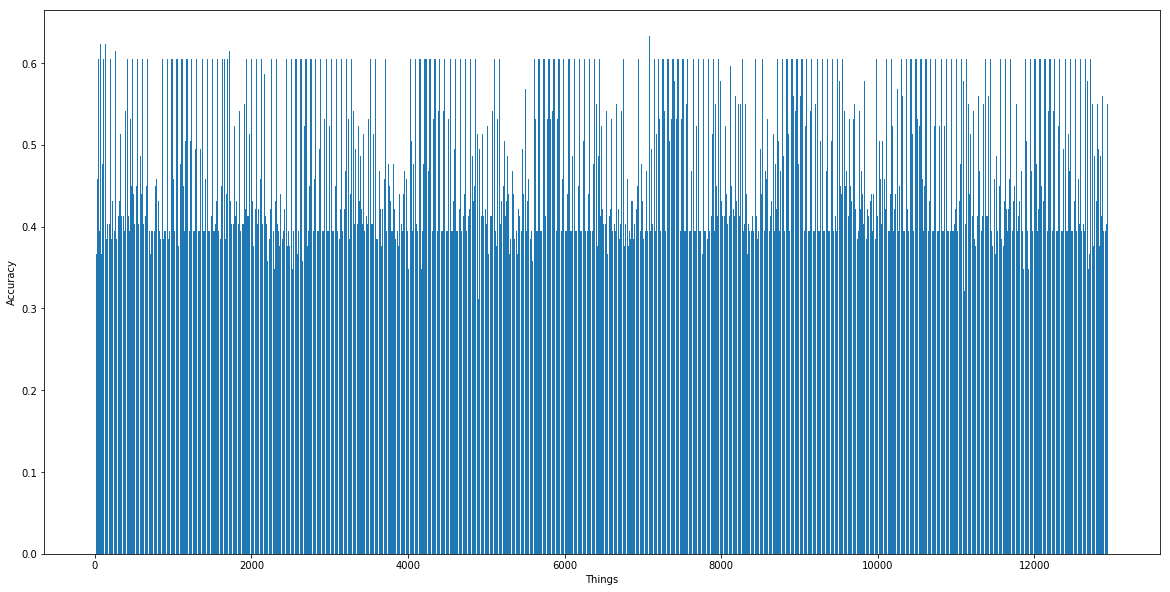

In [40]:
plt.figure(figsize=(20, 10))
plt.bar(np.arange(0, len(result_comb)), result_comb)
plt.xlabel("Things")
plt.ylabel("Accuracy")
plt.show()

In [67]:
hero_df, win_df = create_vector(dpc, 26, 27)
hero_test_df, win_test_df = create_vector(dpc, 28, 28)

clf = MLPClassifier(activation='relu', solver='adam', alpha=0.004, hidden_layer_sizes=(1, 2), 
                    random_state=1, early_stopping=True, beta_1=0.7, beta_2=0.002)
clf.fit(hero_df, win_df.values.ravel())
accuracy_score(clf.predict(hero_test_df), win_test_df)

0.5625

In [56]:
# 0.003 0.8 0.003 2 3

hero_df, win_df = create_vector(dpc, 33, 34)
hero_test_df, win_test_df = create_vector(dpc, 35, 36)

clf = MLPClassifier(activation='relu', solver='adam', alpha=0.003, hidden_layer_sizes=(2, 3), 
                    random_state=1, early_stopping=True, beta_1=0.8, beta_2=0.003)
clf.fit(hero_df, win_df.values.ravel())
accuracy_score(clf.predict(hero_test_df), win_test_df)

0.5045871559633027

In [34]:
hero_df, win_df = create_vector(dpc, 29, 31)
hero_test_df, win_test_df = create_vector(dpc, 32, 32)

clf = MLPClassifier(activation='relu', solver='adam', alpha=0.003, hidden_layer_sizes=(2, 3), 
                    random_state=1, early_stopping=True, beta_1=0.8, beta_2=0.003)
clf.fit(hero_df, win_df.values.ravel())
accuracy_score(clf.predict(hero_test_df), win_test_df)

0.4411764705882353

In [35]:
hero_df, win_df = create_vector(dpc, 26, 27)
hero_test_df, win_test_df = create_vector(dpc, 28, 28)

clf = MLPClassifier(activation='relu', solver='adam', alpha=0.003, hidden_layer_sizes=(2, 3), 
                    random_state=1, early_stopping=True, beta_1=0.8, beta_2=0.003)
clf.fit(hero_df, win_df.values.ravel())
accuracy_score(clf.predict(hero_test_df), win_test_df)

0.671875